In [37]:
import cv2 as cv
import cv2
import numpy as np

In [38]:
left = cv.imread("./assets/left.jpg")

In [39]:
right = cv.imread("./assets/right.jpg")

In [40]:
import matplotlib.pyplot as plt

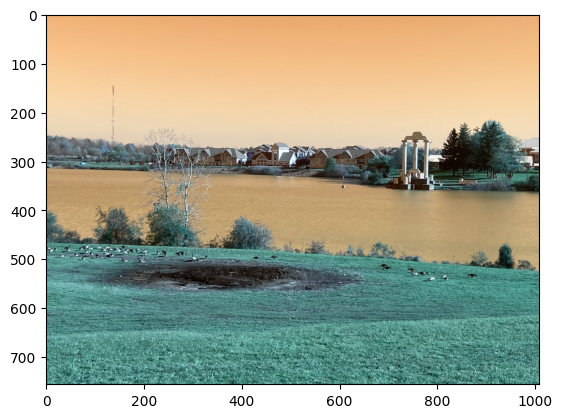

In [41]:
plt.imshow(left)

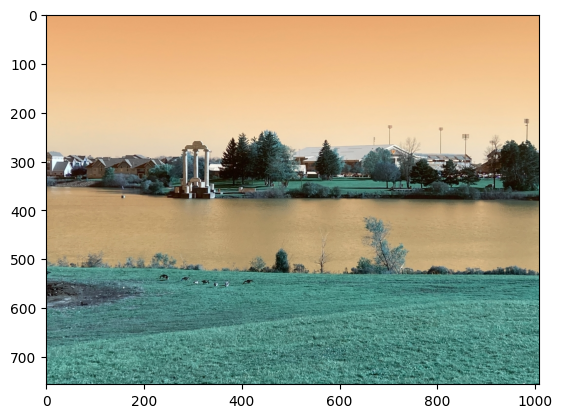

In [42]:
plt.imshow(right)

In [43]:
def detectAndDescribe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    kps = np.float32([kp.pt for kp in kps])
    return (kps, features)

In [44]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB,
ratio, reprojThresh):
     # compute the raw matches and initialize the list of actual
     # matches
     matcher = cv2.DescriptorMatcher_create("BruteForce")
     rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
     matches = []
     # loop over the raw matches
     for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe’s ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
           matches.append((m[0].trainIdx, m[0].queryIdx))
     # computing a homography requires at least 4 matches
     if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
     # compute the homography between the two sets of points
     (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
 reprojThresh)
     # return the matches along with the homograpy matrix
     # and status of each matched point
     return (matches, H, status)
     # otherwise, no homograpy could be computed
     return None

In [45]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB
    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
       # only process the match if the keypoint was successfully
       # matched
       if s == 1:
         # draw the match
         ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
         ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
         cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
    # return the visualization
    return vis

In [48]:
def stitch(images, ratio=0.75, reprojThresh=4.0,showMatches=False):
    # unpack the images, then detect keypoints and extract
    # local invariant descriptors from them
    (imageB, imageA) = images
    (kpsA, featuresA) = detectAndDescribe(imageA)
    (kpsB, featuresB) = detectAndDescribe(imageB)
    # match features between the two images
    M = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
    # if the match is None, then there aren’t enough matched
    # keypoints to create a panorama
    if M is None:
        return None
    (matches, H, status) = M
    result = cv2.warpPerspective(imageA, H,
    (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
    # check to see if the keypoint matches should be visualized
    if showMatches:
        vis = drawMatches(imageA, imageB, kpsA, kpsB, matches,status)
    # return a tuple of the stitched image and the
    # visualization
    return (result, vis)
    # return the stitched image
    return result

In [50]:
result, vis = stitch([left,right], showMatches=True)

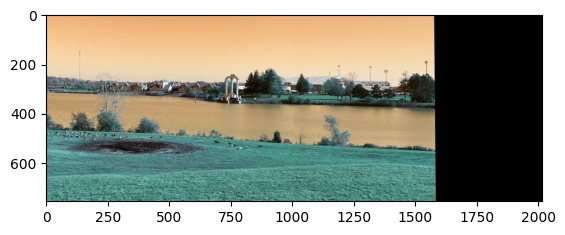

In [51]:
plt.imshow(result)

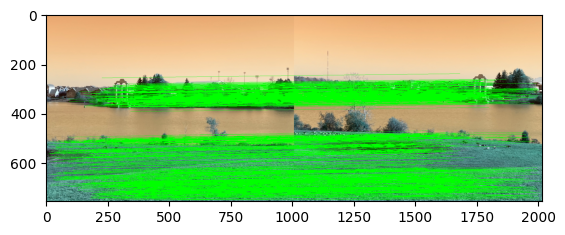

In [52]:
plt.imshow(vis)